# Notebook Iteracion 6 Modelado

### Objetivo: Implementación de clustering como originador de una nueva variable que categoriza los precios y se usa como entrada para el modelo de predicción de precios:
- Analisis de distribución de la variable precio
- Analisis de variables predictoras
- Ejecución de clustering
- Entrenamiento de modelos


In [128]:
# Funciones generales
import sys
sys.path.append('../')
# A medida que avanzan las iteraciones se crearan mas funcinoes transversales
from funciones import *

# Tuneo de hiperparámetros
from sklearn.model_selection import ParameterGrid

# Libreria para manejo de balance de datos
import smogn

# Clustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

**Lectura de datos**
Dada la estabilidad que muestra el resultado de la iteracion 2 sobre las variables predictoras, se utiliza la base resultante de esta

In [129]:
import os 
# get current directory
path = os.getcwd()
# parent directory
path = os.path.abspath('../')
data_model = pd.read_csv(path + "/iteracion_2/datos_iteracion_2.csv")
data_model.head()

,precio,zona,barrio_sector,baños_familiares,area_bruta,numero_niveles,parqueaderos,alcobas_familiares,estrato,area_total,...,closet_de_linos,biblioteca,parqueadero_visitantes,gimnasio,piscina,salon_social,dispositivos_automatizacion,alarma,tipo_cocina_freq,tipo_pisos_freq
0,1100000.0,centro,castilla,1.0,95.0,1.0,0.0,3.0,0.0,95.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.861534,0.596709
1,950000.0,centro,el salvador,1.0,70.0,1.0,0.0,2.0,3.0,70.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.081652,0.596709
2,970000.0,centro,los angeles,1.0,38.0,1.0,0.0,1.0,4.0,38.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.081652,0.596709
3,1400000.0,centro,prado,1.0,50.0,1.0,1.0,2.0,0.0,50.0,...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.861534,0.596709
4,800000.0,centro,12 de octubre,1.0,92.0,1.0,0.0,3.0,2.0,92.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.861534,0.596709


**Distribución de variable precio**

Variable precio en su distribución original luego de las iteraciones 1 y 3, esta será la distribución sobre la cúal se aplique el clustering

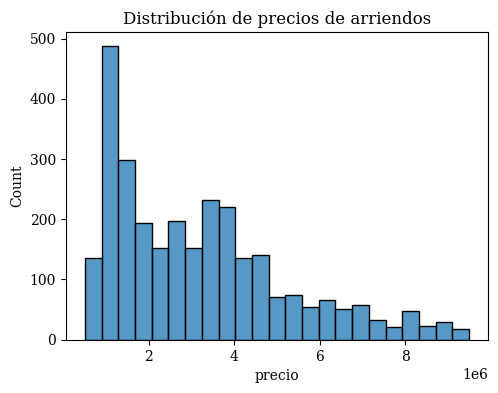

In [130]:
graficar_distribucion_histograma(data_model, 'precio')

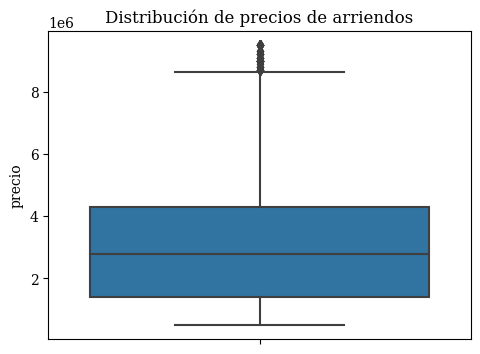

In [131]:
graficar_distribucion_boxplot(data_model, 'precio')

**Separación de las variables**

Las variables obtenidas por el proceso de scraping se dividen en tres tipos que es importante separar para hacer un analisis mas detallado, estas son:
- Variables categóricas: Variables booleana que indican si un inmueble cuenta con una comodidad
- Variables categoricas numéricas: Variables discretas numéricas
- Variables numéricas: Variables continuas

In [132]:
pred_columns = [
    'baños_familiares',
    'area_bruta', 
    'numero_niveles',
    'parqueaderos', 
    'alcobas_familiares', 
    'estrato', 
    'area_total',
    'juegos_infantiles', 
    'balcon', 
    'zona_ropas', 
    'camaras_cctv',
    'cancha_polideportiva', 
    'ascensor', 
    'cancha_squash', 
    'zona_bbq',
    'patio', 
    'unidad_cerrada_conjunto', 
    'zonas_verdes',
    'aire_acondicionado', 
    'jacuzzi', 
    'red_de_Gas', 
    'turco', 
    'porteria_24_7',
    'sauna', 
    'calentador_de_agua', 
    'terraza', 
    'closet_de_linos',
    'biblioteca', 
    'parqueadero_visitantes', 
    'gimnasio', 
    'piscina',
    'salon_social', 
    'dispositivos_automatizacion', 
    'alarma',
    'tipo_cocina_freq', 
    'tipo_pisos_freq'
]
cat_features = ['juegos_infantiles','balcon','zona_ropas','camaras_cctv','cancha_polideportiva','ascensor','cancha_squash','zona_bbq','patio','unidad_cerrada_conjunto','zonas_verdes',
                'aire_acondicionado','jacuzzi','red_de_Gas','turco','porteria_24_7','sauna','calentador_de_agua','terraza','closet_de_linos','biblioteca','parqueadero_visitantes',
                'gimnasio','piscina','salon_social','dispositivos_automatizacion','alarma']
cat_number_fetures = ['baños_familiares', 'numero_niveles', 'parqueaderos', 'alcobas_familiares', 'estrato']
num_features = ['area_bruta', 'area_total','tipo_cocina_freq','tipo_pisos_freq']

**Variables predictoras**

En la iteración 2 el analisis de distribución y correlaciones dió como resultado la eliminación de las variables:

- columns_disc_corr
- numero_niveles
- zona_ropas
- camaras_cctv
- cancha_polideportiva
- cancha_squash
- zona_bbq
- patio
- aire_acondicionado
- jacuzzi
- red_de_Gas
- terraza
- dispositivos_automatizacion
- alarma
- area_total
- porteria_24_7

Se reutiliza estas variables, sin embargo, por criterio del negocio se conservan las siguientes variables dejando su eliminación para un posterior analisis de importancia de variables:

- cancha_polideportiva


In [133]:
columns_disc_corr = [
    "numero_niveles",
    "zona_ropas",
    "camaras_cctv",
    "cancha_squash",
    "zona_bbq",
    "patio",
    "aire_acondicionado",
    "jacuzzi",
    "red_de_Gas",
    "terraza",
    "dispositivos_automatizacion",
    "alarma",
    "area_total",
    "porteria_24_7"
]

**Estandarización**

In [134]:
X = data_model[pred_columns]
Y = data_model['precio']

In [135]:
X_est = estandarizar(X)

**Clustering**

Se procede con la ejecucion del algoritmo de kmeans entre las variables __precio__ y __area_bruta__, esta última por ser la mas relevante en la ejecución del modelo línea base y el análisis de correlaciones

In [136]:
X_est['precio'] = Y.values

In [137]:
x_cluster = X_est[['precio', 'area_bruta']].values
for k in [2,3,4,5]:
    kmeans = KMeans(n_clusters=k, random_state=0, n_init="auto")
    kmeans_labels = kmeans.fit_predict(x_cluster)
    sample_silhouette_values = silhouette_samples(x_cluster, kmeans_labels)
    print("silhouette_score k = {} : {}".format(k , sample_silhouette_values.mean()))

silhouette_score k = 2 : 0.5965131713561477
silhouette_score k = 3 : 0.6348158925476787
silhouette_score k = 4 : 0.6058642604255898
silhouette_score k = 5 : 0.5952737314776967


Segun el cálculo del coeficiente de siluetas se obtiene un mejor resultado para 3 clusters, se selecciona este valor para hacer la división de los datos

Entrenamiento y cálculo de las etiquetas de los clusters

In [138]:
kmeans = KMeans(n_clusters=3, random_state=0, n_init="auto")
kmeans_labels = kmeans.fit_predict(x_cluster)

Se añade la etiqueta cluster como nueva variable de la base de entrenamiento

In [139]:
X_est['cluster'] = kmeans_labels

Se grafica la distribución de los clusters para visualizar la distribución de los grupos

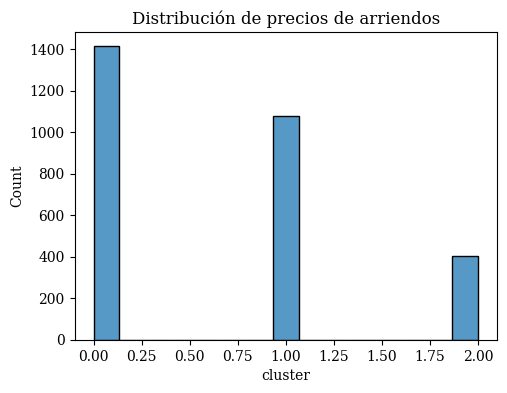

In [140]:
graficar_distribucion_histograma(X_est, 'cluster')

Los rangos de precios de cada cluster son:

In [141]:
print("Cluster 0: ", X_est[X_est['cluster']==0]['precio'].min(), X_est[X_est['cluster']==0]['precio'].max())
print("Cluster 1: ", X_est[X_est['cluster']==1]['precio'].min(), X_est[X_est['cluster']==1]['precio'].max())
print("Cluster 2: ", X_est[X_est['cluster']==2]['precio'].min(), X_est[X_est['cluster']==2]['precio'].max())

Cluster 0:  500000.0 2700000.0
Cluster 1:  2750000.0 5500000.0
Cluster 2:  5600000.0 9500000.0


**Modelo**

La variacion de los hiperparámetros seleccionada corresponde al resultado de multiples ejecuciones observando los resultados obtenidos en los archivos csv que determinaron el aumento, disminución o eliminación de hiperparámetros

Se eliminan las variables de la base de modelado dado los anteriores análisis

In [142]:
x_model = X_est.drop(columns = columns_disc_corr)
x_model = x_model.drop(columns='precio')
y_model = X_est['precio']
imprimir_dimensiones(x_model)

Numero de muestras: 2892, Número de columnas: 23


**Dvisión de los datos:** Entrenamiento 75%, Test 25%

In [143]:
x_train, x_test, y_train, y_test = train_test_split(x_model, y_model, test_size = 0.25, train_size = 0.75, random_state = 17)
print("Tamaño de los Datos de Entrenamiento = ", x_train.shape)
print("Tamaño de los Datos de Validación = ", x_test.shape)
print("Tamaño del Vector de Clases de Entrenamiento = ", y_train.shape)
print("Tamaño del Vector de Clases de Prueba = ", y_test.shape)

Tamaño de los Datos de Entrenamiento =  (2169, 23)
Tamaño de los Datos de Validación =  (723, 23)
Tamaño del Vector de Clases de Entrenamiento =  (2169,)
Tamaño del Vector de Clases de Prueba =  (723,)


**Random Forest**

In [144]:
# Grilla de hiperparámetros
param_grid_rf = ParameterGrid(
                {
                 'n_estimators': [40, 60, 80, 100, 150, 200],
                 'min_samples_split' : [2, 3, 5],
                 'min_samples_leaf' : [1,3, 5],
                 'max_features': [10, 12, 14, 16],
                 'max_depth'   : [2, 3, 5, 7]
                }
             )
# Ejecuciones del modelo
ejecutar_modelo(model = "RandomForestRegressor", 
                x_train=x_train, 
                y_train=y_train, 
                x_test=x_test, 
                y_test=y_test, 
                params=param_grid_rf, 
                filename='RandomForestRegressor')

Modelo: {'max_depth': 2, 'max_features': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 40}
Modelo: {'max_depth': 2, 'max_features': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 60}
Modelo: {'max_depth': 2, 'max_features': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 80}
Modelo: {'max_depth': 2, 'max_features': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Modelo: {'max_depth': 2, 'max_features': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}
Modelo: {'max_depth': 2, 'max_features': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Modelo: {'max_depth': 2, 'max_features': 10, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 40}
Modelo: {'max_depth': 2, 'max_features': 10, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 60}
Modelo: {'max_depth': 2, 'max_features': 10, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estima

**Máquinas de soporte vectorial**

**Gradient Boosting**

In [145]:
param_grid_gb = ParameterGrid({
    'learning_rate' : [.1,.3,.5],
    'max_depth' : [3,5,8],
    'max_features' : ['log2','sqrt'],
    'n_estimators' : [ 45,50, 100, 120],
    'loss': ['squared_error', 'absolute_error', 'huber']
})
# Ejecuciones del modelo
ejecutar_modelo(model = "GradientBoostingRegressor", 
                x_train=x_train, 
                y_train=y_train, 
                x_test=x_test, 
                y_test=y_test, 
                params=param_grid_gb, 
                filename='GradientBoostingRegressor')

Modelo: {'learning_rate': 0.1, 'loss': 'squared_error', 'max_depth': 3, 'max_features': 'log2', 'n_estimators': 45}


Modelo: {'learning_rate': 0.1, 'loss': 'squared_error', 'max_depth': 3, 'max_features': 'log2', 'n_estimators': 50}
Modelo: {'learning_rate': 0.1, 'loss': 'squared_error', 'max_depth': 3, 'max_features': 'log2', 'n_estimators': 100}
Modelo: {'learning_rate': 0.1, 'loss': 'squared_error', 'max_depth': 3, 'max_features': 'log2', 'n_estimators': 120}
Modelo: {'learning_rate': 0.1, 'loss': 'squared_error', 'max_depth': 3, 'max_features': 'sqrt', 'n_estimators': 45}
Modelo: {'learning_rate': 0.1, 'loss': 'squared_error', 'max_depth': 3, 'max_features': 'sqrt', 'n_estimators': 50}
Modelo: {'learning_rate': 0.1, 'loss': 'squared_error', 'max_depth': 3, 'max_features': 'sqrt', 'n_estimators': 100}
Modelo: {'learning_rate': 0.1, 'loss': 'squared_error', 'max_depth': 3, 'max_features': 'sqrt', 'n_estimators': 120}
Modelo: {'learning_rate': 0.1, 'loss': 'squared_error', 'max_depth': 5, 'max_features': 'log2', 'n_estimators': 45}
Modelo: {'learning_rate': 0.1, 'loss': 'squared_error', 'max_depth':

**XGBOOST**

In [146]:
for column in x_train.columns:
    if column not in ['area_bruta', 'tipo_cocina_fre', 'tipo_pisos_freq']:
        x_train[column] = x_train[column].astype('float') 

for column in x_test.columns:
    if column not in ['area_bruta', 'tipo_cocina_fre', 'tipo_pisos_freq']:
        x_test[column] = x_test[column].astype('float') 

In [147]:
param_grid_xgb = ParameterGrid({
    'n_estimators' : [80, 100],
    'max_depth' : [3,5, 7],
    'learning_rate' : [.02,.03, .05],
    'objective' : ['reg:squarederror', 'reg:squaredlogerror'],
    'subsample' : [0.3, 0.5, 0.8, .1],
    'eta' : [.01, .05],
})
# Ejecuciones del modelo
ejecutar_modelo(model = "XGBRegressor", 
                x_train=x_train, 
                y_train=y_train, 
                x_test=x_test, 
                y_test=y_test, 
                params=param_grid_xgb, 
                filename='XGBRegressor')

Modelo: {'eta': 0.01, 'learning_rate': 0.02, 'max_depth': 3, 'n_estimators': 80, 'objective': 'reg:squarederror', 'subsample': 0.3}
Modelo: {'eta': 0.01, 'learning_rate': 0.02, 'max_depth': 3, 'n_estimators': 80, 'objective': 'reg:squarederror', 'subsample': 0.5}
Modelo: {'eta': 0.01, 'learning_rate': 0.02, 'max_depth': 3, 'n_estimators': 80, 'objective': 'reg:squarederror', 'subsample': 0.8}
Modelo: {'eta': 0.01, 'learning_rate': 0.02, 'max_depth': 3, 'n_estimators': 80, 'objective': 'reg:squarederror', 'subsample': 0.1}
Modelo: {'eta': 0.01, 'learning_rate': 0.02, 'max_depth': 3, 'n_estimators': 80, 'objective': 'reg:squaredlogerror', 'subsample': 0.3}
Modelo: {'eta': 0.01, 'learning_rate': 0.02, 'max_depth': 3, 'n_estimators': 80, 'objective': 'reg:squaredlogerror', 'subsample': 0.5}
Modelo: {'eta': 0.01, 'learning_rate': 0.02, 'max_depth': 3, 'n_estimators': 80, 'objective': 'reg:squaredlogerror', 'subsample': 0.8}
Modelo: {'eta': 0.01, 'learning_rate': 0.02, 'max_depth': 3, 'n_est

**Consolidación de mejores resultados:**

Dada las ejecuciones de los modelos con la variación de sus hiperparámetros, se consolida los mejores resultados obtenidos de cada algoritmo. Cabe resaltar que algunas combinaciones de parámetros tienen los mismos resultados en métricas.

**Random Forest**

| R2_train | R2_test | RMSE_train | RMSE_test | MAPE_train | MAPE_test | max_depth | max_features | min_samples_leaf | min_samples_split | n_estimators |
| --- | --- |  --- |  --- |  --- |  --- |  --- | --- |  --- | --- | --- |
| 0.94 | 0.92 | 489626.90 | 589643.00 | 0.13 | 0.15 | 7 | 16 | 5 | 3 | 200 |

**Gradient boosting**

| R2_train | R2_test | RMSE_train | RMSE_test | MAPE_train | MAPE_test | Learning rate | Loss | Max depth | Max features | N estimators |
| --- | --- |  --- |  --- |  --- |  --- |  --- | --- | --- |  --- |  --- | 
| 0.96 | 0.91 | 428595.61 | 614915.30 | 0.11 | 0.15 | 0.1  | huber | 5 | sqrt | 120 |

**XGBoost**

| R2_train | R2_test | RMSE_train | RMSE_test | MAPE_train | MAPE_test | Eta | Learning rate | Max depth | N estimators | Objetive | Subsample |
| --- | --- |  --- |  --- |  --- |  --- |  --- | --- | --- |  --- |  --- | --- |
| 0.95 | 0.92 | 476071.74 | 599257.22 | 0.12 | 0.15 | 0.05  | 0.05 | 5 | 100 | reg:squarederror | 0.3 |

**Conclusiones**

- La implementación del algoritmo kmeans ha dejado como resultado 3 cluster para clasificar los datos, este modelo debe ser parte de la implementación pues determina el punto de entrada para la predicción del precio de arriendos
- Esta estrategia ha sido exitosa pues se ha logrado la métrica propuesta por el negocio (MAPE <= 0.15)
- El algoritmo con mejores resultados a lo largo de las iteraciones ha sido xgboost, en esta iteración no ha sido la diferencia, además de mostrar una rapidez de ejecución muy superior a los demás algoritmos. Este será el seleccionado para la construcción del modelo final
- En la iteración final de este proyecto se entrenará un xgboost con la combinación de hiperparámetros que ha mostrado mejores resultados. A este se le aplicará un método de validación cruzada y un rastreo de importancia de variables para determinar la cantidad final de variables predictoras